In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

In [2]:
data_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data'

In [3]:
upstream_files = glob.glob(os.path.join(data_dir, '*Upstream.txt'))

In [4]:
downstream_files = glob.glob(os.path.join(data_dir, '*Downstream.txt'))

In [5]:
upstream_files[:5]

['/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data/Plate02_A_Upstream.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data/Plate02_H_Upstream.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data/Plate01_D_Upstream.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data/Plate02_G_Upstream.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/analyzed_data/Plate02_B_Upstream.txt']

In [6]:
upstream_files[0].split('/')[-1].split('.txt')[0]

'Plate02_A_Upstream'

In [7]:
def make_table(file_list, r):
    all_table = pd.DataFrame()
    for f in tqdm.tqdm(file_list):
        if os.stat(f).st_size != 0:
            #print('True')
            t = pd.read_csv(f, sep='\t', index_col=0)
            t['rep1_mn'] = t['rep1']/t.loc['NEG','rep1']
            t['rep2_mn'] = t['rep2']/t.loc['NEG','rep2']
            t['rep3_mn'] = t['rep3']/t.loc['NEG','rep3']
            t['RBPmean-NEGmean'] = t['mean']-t.loc['NEG','mean']
            t['|RBPmean-NEGmean|'] = abs(t['RBPmean-NEGmean'])
            t['mean_normalized'] = t['mean']/t.loc['NEG','mean']
            t['Experiment'] = f.split('/')[-1].split('.txt')[0]
            if r=='Downstream':
                t['reporter']='Downstream'#annotating whether it is upstream or downstream
            elif r=='Upstream':
                t['reporter']='Upstream'#annotating whether it is upstream or downstream
            all_table=pd.concat([all_table, t.reset_index()])
            #print(all_table.shape[0])
    return all_table

In [8]:
upstream_df = make_table(upstream_files, 'Upstream')

100%|██████████| 16/16 [00:00<00:00, 29.22it/s]


In [9]:
upstream_df.head()

,index,rep1,rep2,rep3,mean,std,pvalue,stars,well_id,rep1_mn,rep2_mn,rep3_mn,RBPmean-NEGmean,|RBPmean-NEGmean|,mean_normalized,Experiment,reporter
0,NEG,0.728996,0.636929,0.855790,0.740572,0.077703,NaN,NaN,controls,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,Plate02_A_Upstream,Upstream
1,CPSF5,7.552225,6.730881,9.208195,7.830434,1.030314,0.009967,**,controls,10.359763,10.567707,10.759874,7.089862,7.089862,10.573498,Plate02_A_Upstream,Upstream
2,CPSF6,3.359851,4.051399,10.816774,6.076008,3.364096,0.154012,NaN,controls,4.608875,6.360831,12.639517,5.335436,5.335436,8.204482,Plate02_A_Upstream,Upstream
3,HNRNPCL1,0.190025,0.190007,0.201158,0.193730,0.005253,0.012966,*,controls,0.260667,0.298317,0.235056,-0.546842,0.546842,0.261595,Plate02_A_Upstream,Upstream
4,TIAL1,2.018298,2.346810,2.297275,2.220794,0.177107,0.000674,***,Plate02.A01,2.768600,3.684569,2.684390,1.480222,1.480222,2.998756,Plate02_A_Upstream,Upstream


In [10]:
downstream_df = make_table(downstream_files, 'Downstream')

100%|██████████| 16/16 [00:00<00:00, 43.95it/s]


In [11]:
missing_wells_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/activator_redo/Missing_Wells.tsv', sep='\t', header=None)

In [12]:
missing_wells_df.head()

,0,1,2,3
0,Plate01 C,RPS28,C05,Up/Down
1,Plate01 F,THUMPD1,F04,Up/Down
2,Plate01 F,NONO,F05,Up/Down
3,Plate01 G,RBFOX1,G08,Up/Down
4,Plate01 G,HNRNPH1,G12,Up/Down


In [14]:
missing_wells_df['well_id'] = missing_wells_df.apply(lambda x: f"{x[0].split(' ')[0]}.{x[2]}", axis=1)

In [15]:
missing_wells_list = missing_wells_df['well_id'].tolist()

In [16]:
missing_wells_list

['Plate01.C05',
 'Plate01.F04',
 'Plate01.F05',
 'Plate01.G08',
 'Plate01.G12',
 'Plate02.B04',
 'Plate02.D07']

In [17]:
upstream_df = upstream_df[~upstream_df['well_id'].isin(missing_wells_list)]

In [18]:
downstream_df = downstream_df[~downstream_df['well_id'].isin(missing_wells_list)]

In [19]:
upstream_sig_genes = set(upstream_df[(upstream_df['well_id'] != 'controls') & (upstream_df['pvalue'] <= 0.05)].dropna(subset='index')['index'].tolist())

In [20]:
downstream_sig_genes = set(downstream_df[(downstream_df['well_id'] != 'controls') & (downstream_df['pvalue'] <= 0.05)].dropna(subset='index')['index'].tolist())

In [21]:
original_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/analyzed_data/output_tables_may22/candidate_lists'

In [22]:
downstream_activator_orig_list = set(pd.read_csv(os.path.join(original_dir, 'downstream_activator_may22.txt'), sep='\t', header=None)[0])

In [23]:
upstream_activator_orig_list = set(pd.read_csv(os.path.join(original_dir, 'upstream_activator_may22.txt'), sep='\t', header=None)[0])

In [24]:
all_candidates = pd.read_csv('./candidate_list.txt', header=None)[0].tolist()

In [28]:
all_candidates.append('NUDT21')
all_candidates.append('CPSF6')


In [29]:
downstream_activator_ranked_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/analyzed_data/output_tables_may22/downstream_positive_validation_mean_normalized.txt', sep='\t')[['index', 'well_id', 'mean', 'mean_normalized', 'pvalue']].reset_index()
print(downstream_activator_ranked_df.shape)
downstream_activator_ranked_df['rank'] = downstream_activator_ranked_df.apply(lambda x: x['level_0'] + 1, axis=1)
downstream_activator_ranked_df = downstream_activator_ranked_df[['rank', 'index', 'well_id']]

(101, 6)


In [30]:
upstream_activator_ranked_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/analyzed_data/output_tables_may22/upstream_positive_validation_mean_normalized.txt', sep='\t')[['index','well_id', 'mean', 'mean_normalized', 'pvalue']].reset_index()
print(upstream_activator_ranked_df.shape)
upstream_activator_ranked_df['rank'] = upstream_activator_ranked_df.apply(lambda x: x['level_0'] + 1, axis=1)
upstream_activator_ranked_df = upstream_activator_ranked_df[['rank', 'index', 'well_id']]

(111, 6)


In [31]:
upstream_activator_ranked_df.head()

,rank,index,well_id
0,1,CPSF5,DNASU001.B06
1,2,CPSF5,DNASU001.E06
2,3,RNPS1,GYRBP004.A01
3,4,CPSF6,GYRBP005.C12
4,5,CSTF1,DNASU001.H05


In [32]:
downstream_activator_ranked_df.head()

,rank,index,well_id
0,1,CSTF1,DNASU001.H05
1,2,TOB2,DNASU001.F07
2,3,PRRC2B,Missing_Wells.B01
3,4,PARN,GYRBP007.C07
4,5,RBM11,GYRBP003.H09


In [33]:
downstream_redo_ranking_df = downstream_df[(downstream_df['well_id']!= 'controls') & (downstream_df['pvalue'] < 0.05)].sort_values(by = ['mean_normalized', 'pvalue'], ascending = [False, True]).reset_index()
downstream_redo_ranking_df = downstream_redo_ranking_df.drop('level_0', axis=1).reset_index()
downstream_redo_ranking_df['rank'] = downstream_redo_ranking_df.apply(lambda x: x['level_0'] + 1, axis=1)
downstream_redo_ranking_df = downstream_redo_ranking_df[['rank', 'index', 'well_id']]

In [34]:
downstream_redo_ranking_df = downstream_redo_ranking_df.drop_duplicates(subset='index')

In [35]:
downstream_redo_ranking_df

,rank,index,well_id
0,1,DDX17,Plate02.A08
1,2,PARN,Plate02.A07
2,3,PRRC2B,Plate02.E04
3,4,RBM11,Plate01.D09
4,5,GTSF1,Plate01.B06
...,...,...,...
101,102,ZRANB2,Plate02.H02
102,103,PEG10,Plate02.G02
103,104,BUD13,Plate01.H09
104,105,MKI67IP,Plate01.H08


In [36]:
upstream_redo_ranking_df = upstream_df[(upstream_df['well_id']!= 'controls') & (upstream_df['pvalue'] < 0.05)].sort_values(by = ['mean_normalized', 'pvalue'], ascending = [False, True]).reset_index()
upstream_redo_ranking_df = upstream_redo_ranking_df.drop('level_0', axis=1).reset_index()
upstream_redo_ranking_df['rank'] = upstream_redo_ranking_df.apply(lambda x: x['level_0'] + 1, axis=1)
upstream_redo_ranking_df = upstream_redo_ranking_df[['rank', 'index', 'well_id']]

In [37]:
upstream_redo_ranking_df = upstream_redo_ranking_df.drop_duplicates(subset='index')

In [38]:
upstream_redo_ranking_df

,rank,index,well_id
0,1,CPSF5,Plate01.C01
2,3,CSTF1,Plate01.H03
3,4,RNPS1,Plate02.E02
4,5,CPSF6,Plate02.G05
5,6,GRB2,Plate01.C06
...,...,...,...
75,76,BTG4,Plate01.B02
76,77,SNW1,Plate01.B04
77,78,BTG1,Plate01.F01
78,79,PEG10,Plate02.G02


In [39]:
from scipy import stats

SignificanceResult(statistic=0.7265614762829822, pvalue=7.341762376591674e-12)


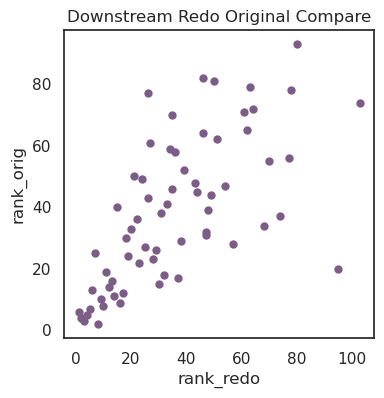

In [41]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("white")


down_redo_original = pd.merge(downstream_redo_ranking_df, downstream_activator_ranked_df, on='index', suffixes=['_redo', '_orig'])
sns.scatterplot(down_redo_original, x='rank_redo', y='rank_orig', linewidth=0, color='#7C5D86')
plt.title('Downstream Redo Original Compare')
print(stats.spearmanr(down_redo_original['rank_redo'], down_redo_original['rank_orig']))

SignificanceResult(statistic=0.6793816818737717, pvalue=4.542577981288546e-09)

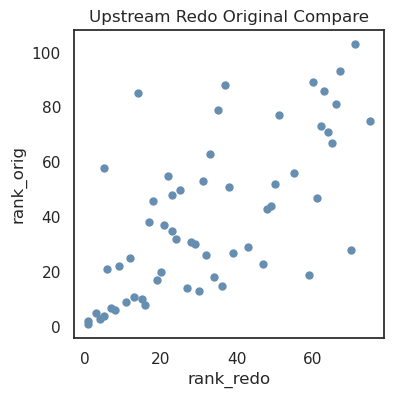

In [42]:
up_redo_original = pd.merge(upstream_redo_ranking_df, upstream_activator_ranked_df, on='index', suffixes=['_redo', '_orig'])
sns.scatterplot(up_redo_original, x='rank_redo', y='rank_orig',linewidth=0, color='#668EB1')
plt.title('Upstream Redo Original Compare')
stats.spearmanr(up_redo_original['rank_redo'], up_redo_original['rank_orig'])

In [43]:
def assign_candidates(df):
    if df['index'] in upstream_sig_genes.intersection(downstream_sig_genes):
        return 'location_independent'
    elif df['index'] in upstream_sig_genes-downstream_sig_genes:
        return 'upstream'
    elif df['index'] in downstream_sig_genes-upstream_sig_genes:
        return 'downstream'

In [44]:
def assign_candidates_original(df):
    if df['index'] in upstream_activator_orig_list.intersection(downstream_activator_orig_list):
        return 'location_independent'
    elif df['index'] in upstream_activator_orig_list-downstream_activator_orig_list:
        return 'upstream'
    elif df['index'] in downstream_activator_orig_list-upstream_activator_orig_list:
        return 'downstream'

In [45]:
down_redo_original['category'] = down_redo_original.apply(assign_candidates, axis=1)

In [46]:
down_redo_original['category_original'] = down_redo_original.apply(assign_candidates_original, axis=1)

In [47]:
up_redo_original['category'] = up_redo_original.apply(assign_candidates, axis=1)

In [48]:
up_redo_original['category_original'] = up_redo_original.apply(assign_candidates_original, axis=1)

In [68]:
up_redo_original.sort_values(by='rank_orig')[up_redo_original.sort_values(by='rank_orig')['category']==up_redo_original.sort_values(by='rank_orig')['category_original']].head(5)

,rank_redo,index,well_id_redo,rank_orig,well_id_orig,category,category_original
3,4,RNPS1,Plate02.E02,3,GYRBP004.A01,upstream,upstream
8,8,RBM11,Plate01.D09,6,GYRBP003.H09,location_independent,location_independent
7,7,TRNAU1AP,Plate02.C02,7,GYRBP003.F10,location_independent,location_independent
15,16,RBM14,Plate01.H05,8,GYRBP001.G07,location_independent,location_independent
10,11,MBNL1,Plate02.B05,9,GYRBP005.B03,location_independent,location_independent


In [69]:
down_redo_original.sort_values(by='rank_redo').head(5)

,rank_redo,index,well_id_redo,rank_orig,well_id_orig,category,category_original
0,1,DDX17,Plate02.A08,6,GYRBP007.F08,location_independent,downstream
1,2,PARN,Plate02.A07,4,GYRBP007.C07,location_independent,location_independent
2,3,PRRC2B,Plate02.E04,3,Missing_Wells.B01,location_independent,location_independent
3,4,RBM11,Plate01.D09,5,GYRBP003.H09,location_independent,location_independent
4,5,GTSF1,Plate01.B06,7,GYRBP002.B06,location_independent,location_independent


In [70]:
secondary_screen_list = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley/diff_apa_labrat/notebook/candidate_list.txt', sep='\t', header=None)[0].tolist()

In [71]:
upstream_df_candidate_vals = upstream_df[upstream_df['index'].isin(secondary_screen_list)].sort_values(by='mean_normalized', ascending=False)

In [72]:
downstream_df_candidate_vals = downstream_df[downstream_df['index'].isin(secondary_screen_list)].sort_values(by='mean_normalized', ascending=False)

In [73]:
set1 = upstream_activator_orig_list.intersection(downstream_activator_orig_list)
set2 = upstream_sig_genes.intersection(downstream_sig_genes)

up_common = upstream_df_candidate_vals[upstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index')
down_common = downstream_df_candidate_vals[downstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index')

/tmp/ipykernel_1830081/2344805300.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=df_pivoted.sort_values(by=['condition', 'value'], ascending=[False, False]), x='index', y='value', hue='condition',


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, 'GRB2'),
  Text(1, 0, 'RBM11'),
  Text(2, 0, 'TRNAU1AP'),
  Text(3, 0, 'RBM5'),
  Text(4, 0, 'PRRC2B'),
  Text(5, 0, 'MBNL1'),
  Text(6, 0, 'PPIA'),
  Text(7, 0, 'EIF4B'),
  Text(8, 0, 'LGALS3'),
  Text(9, 0, 'PRPF4'),
  Text(10, 0, 'WDR6'),
  Text(11, 0, 'SRP68'),
  Text(12, 0, 'GTSF1'),
  Text(13, 0, 'ZC3HAV1'),
  Text(14, 0, 'RBM14'),
  Text(15, 0, 'PARN'),
  Text(16, 0, 'SAMD4A'),
  Text(17, 0, 'EIF4H'),
  Text(18, 0, 'RBM10'),
  Text(19, 0, 'PCBP1'),
  Text(20, 0, 'APOBEC3A'),
  Text(21, 0, 'YWHAG'),
  Text(22, 0, 'YTHDF1'),
  Text(23, 0, 'SMNDC1'),
  Text(24, 0, 'MBNL2'),
  Text(25, 0, 'LSM1'),
  Text(26, 0, 'AHNAK'),
  Text(27, 0, 'TPD52L2')])

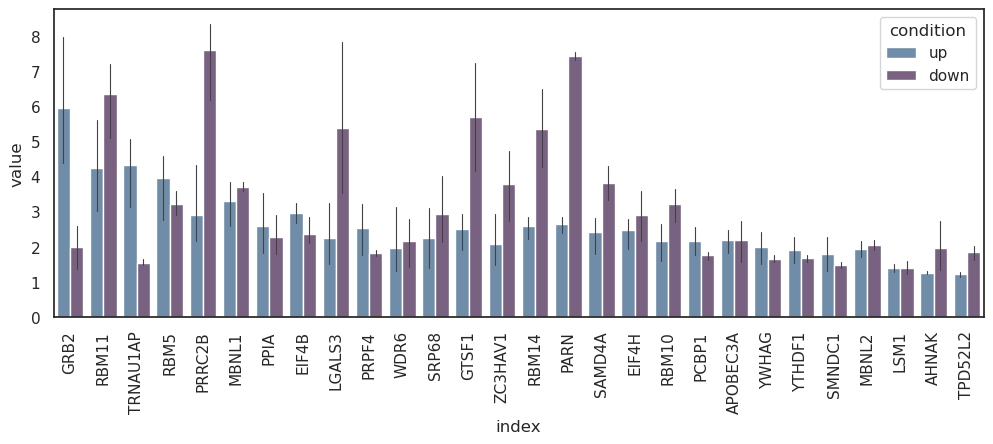

In [74]:
common_plot = up_common.merge(down_common, on='index', suffixes=['_up', '_down']).set_index('index').sort_values(by=['mean_normalized_up', 'mean_normalized_down'], ascending=[False,False])
common_plot = common_plot[['rep1_mn_up','rep2_mn_up', 'rep3_mn_up', 'rep1_mn_down','rep2_mn_down', 'rep3_mn_down']]
# Pivot the dataframe
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style('white')
df_pivoted = common_plot.melt(ignore_index=False, var_name='rep_condition', value_name='value').reset_index()

# Extracting rep and condition information
df_pivoted['rep'] = df_pivoted['rep_condition'].str.extract('(rep\d)')
df_pivoted['condition'] = df_pivoted['rep_condition'].str.extract('(up|down)')

# Dropping the original 'rep_condition' column
df_pivoted.drop(columns=['rep_condition'], inplace=True)
sns.barplot(data=df_pivoted.sort_values(by=['condition', 'value'], ascending=[False, False]), x='index', y='value', hue='condition', 
           palette=['#668EB1','#7C5D86'], hue_order=['up', 'down'],
           errwidth=0.8)
plt.xticks(rotation=90)


/tmp/ipykernel_1830081/1848942514.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=upstream_df_candidate_vals_pivoted, x='index', y='value', errwidth=0.8)


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'RNPS1'),
  Text(1, 0, 'UBE2I'),
  Text(2, 0, 'ZC3H18'),
  Text(3, 0, 'RPS19BP1'),
  Text(4, 0, 'LSM10'),
  Text(5, 0, 'CNOT3')])

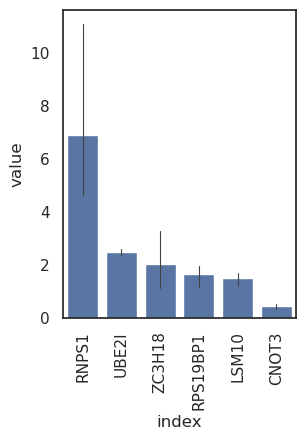

In [76]:
set1 = upstream_activator_orig_list - downstream_activator_orig_list
set2 = upstream_sig_genes - downstream_sig_genes
upstream_df_candidate_vals_pivoted = upstream_df_candidate_vals[upstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

# Extracting rep and condition information
sns.set(rc={'figure.figsize':(3,4)})
sns.set_style('white')
sns.barplot(data=upstream_df_candidate_vals_pivoted, x='index', y='value', errwidth=0.8)
plt.xticks(rotation=90)


/tmp/ipykernel_1830081/1372697373.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=downstream_df_candidate_vals_pivoted, x='index', y='value', color='#7C5D86', errwidth=0.8)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'RBM22'),
  Text(1, 0, 'ZMAT3'),
  Text(2, 0, 'SCAF8'),
  Text(3, 0, 'PCBP3'),
  Text(4, 0, 'NUP35'),
  Text(5, 0, 'CDC42EP4'),
  Text(6, 0, 'HNRNPF'),
  Text(7, 0, 'NANOS3'),
  Text(8, 0, 'CNOT2'),
  Text(9, 0, 'STAU2'),
  Text(10, 0, 'RBM4'),
  Text(11, 0, 'PPP1CA'),
  Text(12, 0, 'HNRNPH2'),
  Text(13, 0, 'DZIP3'),
  Text(14, 0, 'RBM42'),
  Text(15, 0, 'ZC3H7A'),
  Text(16, 0, 'SYMPK'),
  Text(17, 0, 'SRSF2')])

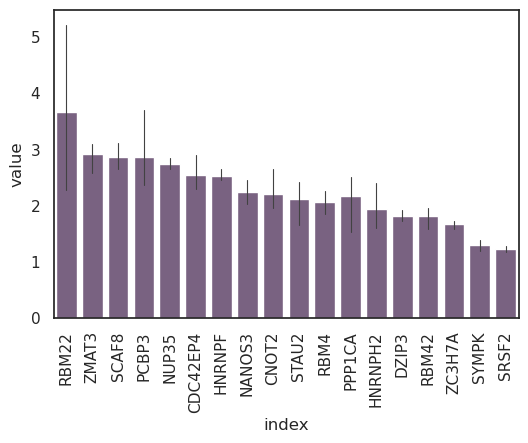

In [77]:
set1 = downstream_activator_orig_list - upstream_activator_orig_list
set2 = downstream_sig_genes - upstream_sig_genes
downstream_df_candidate_vals_pivoted = downstream_df_candidate_vals[downstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

# Extracting rep and condition information
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style('white')
sns.barplot(data=downstream_df_candidate_vals_pivoted, x='index', y='value', color='#7C5D86', errwidth=0.8)
plt.xticks(rotation=90)

/tmp/ipykernel_1830081/723739508.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=df_pivoted.sort_values(by=['condition', 'value'], ascending=[False, False]), x='index', y='value', hue='condition',
/tmp/ipykernel_1830081/723739508.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=upstream_df_candidate_vals_pivoted, x='index', y='value', errwidth=0.8,
/tmp/ipykernel_1830081/723739508.py:21: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=downstream_df_candidate_vals_pivoted, x='index', y='value', color='#668EB1', errwidth=0.8,


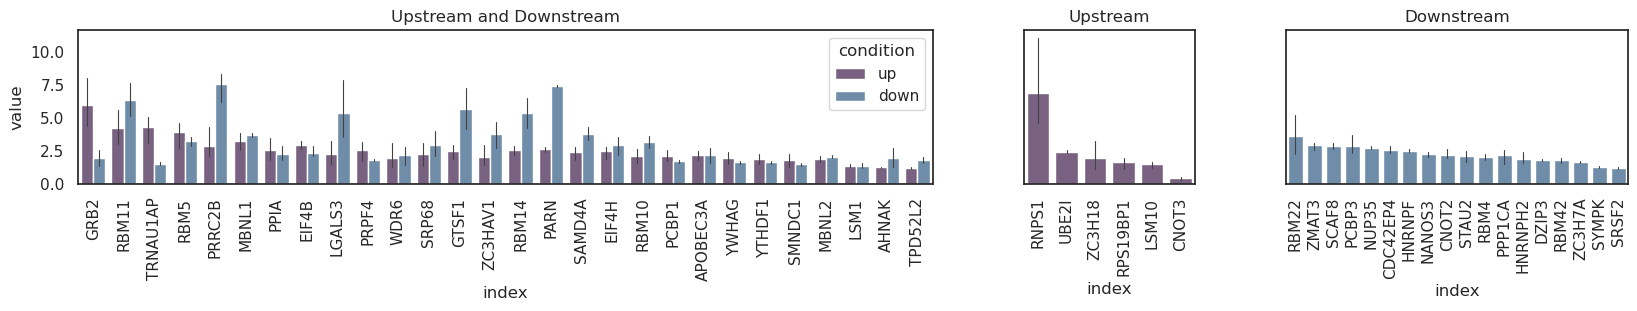

In [80]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,2), gridspec_kw={'width_ratios': [5,1,2]})

sns.barplot(data=df_pivoted.sort_values(by=['condition', 'value'], ascending=[False, False]), x='index', y='value', hue='condition', 
           palette=['#7C5D86','#668EB1'], hue_order=['up', 'down'],
           errwidth=0.8, 
           ax=axes[0])

set1 = upstream_activator_orig_list - downstream_activator_orig_list
set2 = upstream_sig_genes - downstream_sig_genes
upstream_df_candidate_vals_pivoted = upstream_df_candidate_vals[upstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

sns.barplot(data=upstream_df_candidate_vals_pivoted, x='index', y='value', errwidth=0.8,
           ax=axes[1], 
           color='#7C5D86')


set1 = downstream_activator_orig_list - upstream_activator_orig_list
set2 = downstream_sig_genes - upstream_sig_genes
downstream_df_candidate_vals_pivoted = downstream_df_candidate_vals[downstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

sns.barplot(data=downstream_df_candidate_vals_pivoted, x='index', y='value', color='#668EB1', errwidth=0.8,
           ax=axes[2])

axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=90)
axes[2].tick_params(axis='x', rotation=90)

axes[0].set_title('Upstream and Downstream')
axes[1].set_title('Upstream')
axes[2].set_title('Downstream')


# plt.savefig('second_round_candidates_ranked.png')
# plt.savefig('second_round_candidates_ranked.svg')
# plt.savefig('second_round_candidates_ranked.jpg')

plt.savefig('second_round_candidates_ranked_shorter.png')
plt.savefig('second_round_candidates_ranked_shorter.svg')
plt.savefig('second_round_candidates_ranked_shorter.jpg')






In [81]:
fig, axes = plt.subplots(2, 3, sharey=True,sharex=True, figsize=(20,3), gridspec_kw={'width_ratios': [5,1,2]})

sns.barplot(data=df_pivoted.sort_values(by=['value', 'condition'], ascending=[False, True]), x='index', y='value', hue='condition', 
           palette=['#7C5D86', '#668EB1'], hue_order=['down', 'up'],
           errwidth=0.8, 
           ax=axes[1,0])

set1 = upstream_activator_orig_list - downstream_activator_orig_list
set2 = upstream_sig_genes - downstream_sig_genes
upstream_df_candidate_vals_pivoted = upstream_df_candidate_vals[upstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

sns.barplot(data=upstream_df_candidate_vals_pivoted, x='index', y='value', errwidth=0.8,
           ax=axes[1,1], 
           color='#668EB1')


set1 = downstream_activator_orig_list - upstream_activator_orig_list
set2 = downstream_sig_genes - upstream_sig_genes
downstream_df_candidate_vals_pivoted = downstream_df_candidate_vals[downstream_df_candidate_vals['index'].isin(set1.intersection(set2))].dropna(subset='stars').drop_duplicates('index').set_index('index')[['rep1_mn', 'rep2_mn', 'rep3_mn']].melt(ignore_index=False, var_name='rep', value_name='value').reset_index()

sns.barplot(data=downstream_df_candidate_vals_pivoted, x='index', y='value', color='#7C5D86', errwidth=0.8,
           ax=axes[1,2])

axes[1,0].tick_params(axis='x', rotation=90)
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,2].tick_params(axis='x', rotation=90)

axes[1,0].set_title('Upstream and Downstream')
axes[1,1].set_title('Upstream')
axes[1,2].set_title('Downstream')

color_mapping = {'known': '#668EB1', 'novel': '#EEC33E'}
colors = [color_mapping[known_novel_apa.get(gene, 'novel')] for gene in indices]

# Add color rectangles
for i, color in enumerate(colors):
    axes[0,0][.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Set the x-axis with gene names
axes[0,0].set_xticks(range(len(indices)))
axes[0,0].set_xticklabels(indices, rotation=90)
axes[0,0].set_yticks([])

# Add labels for the color bar
#for idx, gene in enumerate(indices):
    #label = known_novel_apa.get(gene, 'novel')
    #ax.text(idx + 0.5, 0.5, label, ha='center', va='center', fontsize=8, color='white' if label == 'known' else 'black')

# Set plot limits and title
ax.set_xlim(0, len(indices))
ax.set_ylim(0, 1)
ax.set_title('Known vs Novel APA Sites')

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (2871505848.py, line 38)